In [1]:
import matplotlib.pyplot as plt
from nilearn.glm.first_level import FirstLevelModel
from nilearn import image, plotting
import pandas as pd
from __future__ import division
import shutil as sh
from os.path import join 
from glob import glob
import itertools
from distutils.dir_util import copy_tree
import shutil as shutil
from glob import glob
import pandas as pd
import numpy as np
from subprocess import check_call
import matplotlib.pyplot as plt
#from utilities import ensure_dir, get_n_vols
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
from numpy import linspace, loadtxt, ones, convolve
from nipype.interfaces.dcm2nii import Dcm2niix, Dcm2nii
#import nipype_init_new
#nipype_init_new.init()
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix,ConnectivityMeasure
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, view_img, plot_matrix, plot_glass_brain
from nilearn.image import concat_imgs, mean_img, load_img, index_img, math_img, resample_img
from nilearn.masking import apply_mask
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, view_img, plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn import plotting
from statsmodels.sandbox.stats.multicomp import multipletests as multi
from scipy.stats import norm
import statsmodels.stats.multitest as ssm
import statsmodels
import seaborn as sns
from scipy.stats import pearsonr,ttest_ind
from sklearn.model_selection import StratifiedKFold,permutation_test_score
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVR
import time
import os

/home/haiyanwu/miniconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/haiyanwu/miniconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def pad_vector(contrast_, n_columns):
    """A small routine to append zeros in contrast vectors"""
    return np.hstack((contrast_, np.zeros(n_columns - len(contrast_))))
def ensure_dir(path):
    d = os.path.dirname(path)
    if not os.path.exists(d):
        os.makedirs(d)
def get_n_vols(iname):
    img = load_img(iname)
    dims=np.shape(image.get_data(img))
    return 1 if len(dims) < 4 else dims[3]
def compute_contrast(design_matrices,contrast_name):
    dmcols=[design_matrices[0].columns.values.tolist(),design_matrices[1].columns.values.tolist(),
            design_matrices[2].columns.values.tolist(),design_matrices[3].columns.values.tolist()]
    for i in range(len(dmcols)):
        for j in range(len(dmcols[i])):
            if contrast_name==dmcols[i][j]:
                dmcols[i][j]=1
            else:
                dmcols[i][j]=0
    return dmcols
def list_substract(a,b):
    new_list=[]
    for i in range(len(a)):
        new_list.append([])
        for j in range(len(a[i])):
            new_list[i].append(0)
            new_list[i][j]=a[i][j]-b[i][j]
    return new_list

In [4]:
base_dir='/media/haiyanwu/HDD4/fmri2019/'
beta_dir=base_dir+'2.GLM/3.GLM_SPM/results/GLM10/betamap/'
t_dir=base_dir+'2.GLM/3.GLM_SPM/results/GLM10/tmap/'
ensure_dir(beta_dir)
ensure_dir(t_dir)

In [5]:
subList=[102,103,105,107,108,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,127,128,129,130,131,132]
len(subList)

26

In [6]:
# considering some over time trials were removed so the trial number of each session was not the same, we didn't combin four sessions together to run the GLM 

In [7]:

tr=2

for subno in subList:

    subdir_beta=beta_dir+"sub-%03d/"%subno
    ensure_dir(subdir_beta)
    subdir_t=t_dir+"sub-%03d/"%subno
    ensure_dir(subdir_t)




    n_columns=[]
    design_matrices=[]
    func_data=[]
    for sesno in [1,2,3,4]:
        ## Prepare data and analysis parameters
        # load functional images
        fd=load_img(base_dir+"fmriprep-deriv/fmriprep/sub-%03d/ses-%01d/func/sub-%03d_ses-%01d_preproc_smoothed6_masked.nii.gz"%(subno,sesno,subno,sesno))
        n_scans=get_n_vols(fd)
        func_data.append(fd)

        # load the events file
        ex_events=pd.read_csv(base_dir+"2.GLM/event_files_noDelete/sub-%03d/sub-%03d_ses-%01d_task-ua%01d_bold.tsv"%(subno,subno,sesno,sesno), sep="\t")
        ex_events['trial_type']='exclusion'
        ex_events['duration']=0
        ex_events=ex_events.rename(columns={'time_onset_new':'onset'})
        ex_events=ex_events.loc[ex_events['rt']>=4,['onset','trial_type','duration']]


        events=pd.read_csv(base_dir+"2.GLM/event_files/sub-%03d/sub-%03d_ses-%01d_task-ua%01d_bold.tsv"%(subno,subno,sesno,sesno), sep="\t")
        events=events.rename(columns={'time_onset_new':'onset'})
        events['duration']=0
        events=events.reset_index(drop=True)
        events['trial_type']=list(map(lambda x: 'pos' if x==1 else 'neg' ,events['islie']))
        events=events[['onset','trial_type','duration']]
        evs=pd.concat([events,ex_events])
        evs=evs.reset_index(drop=True)

        evs.to_csv(base_dir+"2.GLM/event_files_noDelete/sub-%03d/sub-%03d_ses-%01d_task-ua%01d_bold_nilearn.tsv"%(subno,subno,sesno,sesno),sep = '\t', index=False)

    #     # load the confound file
    #     confounds=pd.read_table(base_dir+"2.GLM/confound_files/sub-%03d/ses-%01d/sub-%03d_ses-%01d_confound.txt"%(subno,sesno,subno,sesno),header=None,sep=',')

    #     frame_times=np.arange(n_scans) * tr
    #     dm=make_first_level_design_matrix(
    #                 frame_times=frame_times, events=evs, drift_model='cosine', high_pass=1/128,
    #                 add_regs=confounds, hrf_model='spm',min_onset=0)
    #     n_columns.append(dm.shape[1])
    #     design_matrices.append(dm)



   
    # glm_comb = FirstLevelModel(t_r=tr,
    #                     slice_time_ref=1, # default is 0, but in SPM default is 1; used the middle slice
    #                     hrf_model='spm + derivative', # block design: spm; event-related: spm + derivative
    #                     noise_model='ar1',
    #                     drift_model='cosine',
    #                     high_pass=1/128,
    #                     standardize=False,
    #                     min_onset=0,
    #                     mask_img=False,
    #                     smoothing_fwhm=None,
    #                     verbose=0
    #                     )
    # starttime = time.time()
    # glm_comb = glm_comb.fit(func_data,design_matrices=design_matrices)
    # print("- %f"%(time.time()-starttime))



    # basic_contrasts=dict()
    # # Generate the contrasts
    # for cname in ['pos','neg']:
    #     temp_name=cname
    #     temp_contrast=compute_contrast(design_matrices,cname)
    #     basic_contrasts[temp_name]=temp_contrast




    # from nilearn import plotting
    # # Iterate on contrasts
    # for index, (contrast_id, contrast_val) in enumerate(basic_contrasts.items()):
        
    #     ## estimate the contasts
    #     ## note that the model implictly compute a fixed effects across the two sessions
    #     ## effect size
    #     eff_map = glm_comb.compute_contrast(
    #         contrast_val, output_type='effect_size')
    #     t_map = glm_comb.compute_contrast(
    #         contrast_val, stat_type='t', output_type='stat')


    #     eff_map.to_filename(join(subdir_beta, 'sub-%03d_%s_eff_map.nii.gz'%(subno,contrast_id)))
    #     t_map.to_filename(join(subdir_t, 'sub-%03d_%s_t_map.nii'%(subno,contrast_id)))

In [6]:
# migrate functions in nistats to nilearn
# https://nilearn.github.io/nistats_migration.html#design-matrix
from nilearn.glm.first_level import FirstLevelModel
#from nistats.thresholding import map_threshold # can not be migrate directly
from nilearn.glm import threshold_stats_img
from nilearn.reporting import get_clusters_table
from nilearn.plotting import plot_contrast_matrix, plot_design_matrix
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.second_level import SecondLevelModel

In [38]:
contrasts=[]
for subno in subList:
    subdir_beta=beta_dir+"sub-%03d/"%subno
    pos=load_img(subdir_beta+'sub-%03d_pos_eff_map.nii.gz'%(subno))
    neg=load_img(subdir_beta+'sub-%03d_neg_eff_map.nii.gz'%(subno))
    contrast=math_img('img1 - img2',img1=pos,img2=neg)

    contrasts.append(contrast)
dm2 = pd.DataFrame([1] * len(contrasts),columns=['intercept'])
second_level_model = SecondLevelModel(smoothing_fwhm=None)
second_level_model = second_level_model.fit(contrasts,design_matrix=dm2)
z_map = second_level_model.compute_contrast(output_type='z_score')



In [65]:
contrasts=[]
for subno in subList:
    subdir_beta=beta_dir+"sub-%03d/"%subno
    pos=load_img(subdir_beta+'sub-%03d_pos_eff_map.nii.gz'%(subno))
    neg=load_img(subdir_beta+'sub-%03d_neg_eff_map.nii.gz'%(subno))
    contrast=math_img('img1 - img2',img1=neg,img2=pos)

    contrasts.append(contrast)
dm2 = pd.DataFrame([1] * len(contrasts),columns=['intercept'])
second_level_model = SecondLevelModel(smoothing_fwhm=None)
second_level_model = second_level_model.fit(contrasts,design_matrix=dm2)
z_map = second_level_model.compute_contrast(output_type='z_score')



In [39]:
z_map.to_filename(beta_dir+'GLM10_zmap.nii')

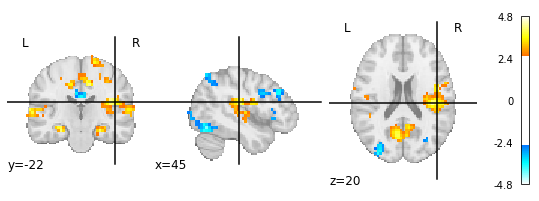

In [66]:
clean_map, thres = threshold_stats_img(
        z_map, height_control='fpr',alpha=.01, cluster_threshold=20)

plotting.plot_stat_map(
        clean_map, threshold=thres, colorbar=True,
        title='',cut_coords=(45,-22,20))
table = get_clusters_table(clean_map, stat_threshold=thres,
                        cluster_threshold=20,
                        two_sided=True)
clean_map.to_filename(beta_dir+'GLM10_01neg.nii')
#table.to_csv(beta_dir+'table-GLM10.csv')
plotting.show()
        

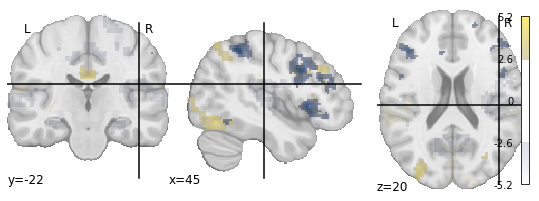

In [62]:
from nilearn import datasets
from nilearn.image import resample_to_img
clean_map_rep=load_img(beta_dir+'GLM10_01_rep.nii')
template=datasets.load_mni152_template(resolution=1)
#resampled_clean_map=resample_to_img(clean_map,template)
#resampled_clean_map_rep=resample_to_img(clean_map_rep,template)
# Choose colormap
from matplotlib.colors import ListedColormap
cmap1 = plt.cm.cividis
cmap2 = plt.cm.get_cmap("cividis_r")

# Get the colormap colors
my_cmap1 = cmap1(np.arange(cmap1.N))
my_cmap2 = cmap2(np.arange(cmap2.N))

# Set alpha
my_cmap1[:,-1] = np.linspace(0, 0.7, cmap1.N)
my_cmap2[:,-1] = np.linspace(0, 0.7, cmap2.N)

# Create new colormap
my_cmap1 = ListedColormap(my_cmap1)
my_cmap2 = ListedColormap(my_cmap2)

display=plotting.plot_stat_map(
        clean_map, threshold=thres, colorbar=True,vmax=5.2,
        title='',cut_coords=(45,-22,20),cmap=my_cmap1,bg_img=template,black_bg=False)
display.add_overlay(clean_map_rep, cmap = my_cmap2,)


plotting.show()

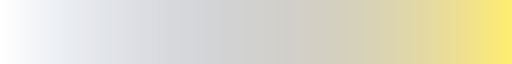

In [63]:
my_cmap1

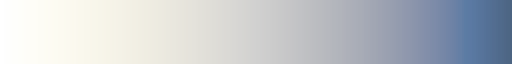

In [64]:
my_cmap2

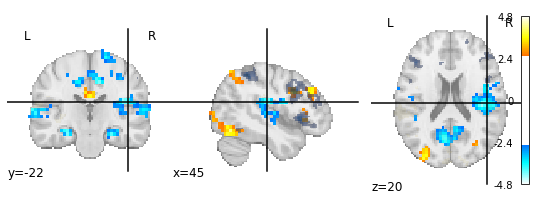

In [55]:
display=plotting.plot_stat_map(
        clean_map, threshold=thres, colorbar=True,
        title='',cut_coords=(45,-22,20))
display.add_overlay(clean_map_rep, cmap = my_cmap2)

In [43]:
thres

2.575829303548901

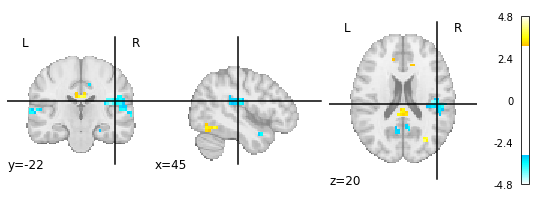

In [9]:
plotting.plot_stat_map(
        clean_map, threshold=thres, colorbar=True,
        title='')